<a href="https://colab.research.google.com/github/michaelsyao/AI_in_Finance/blob/main/07_dense_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dense Neural Networks

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

os.environ['PYTHONHASHSEED'] = '0'

## The Data

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [8]:
data = data.resample('1h', label='right').last().ffill()

In [9]:
list(data.loc['2019-10-01 00:00:00':'2019-10-01 02:00:00'].resample('1h'))

[(Timestamp('2019-10-01 01:00:00', freq='H'),                      EUR_USD
  Date                        
  2019-10-01 01:00:00   1.0896),
 (Timestamp('2019-10-01 02:00:00', freq='H'),                      EUR_USD
  Date                        
  2019-10-01 02:00:00    1.089)]

In [10]:
data = data.resample('1h', label='right').last().ffill()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 02:00:00 to 2020-01-01 01:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


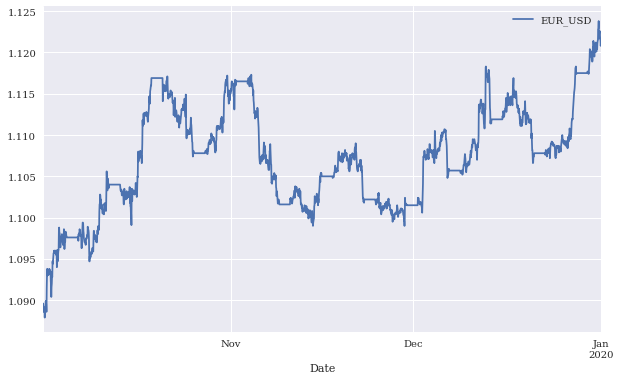

In [12]:
data.plot(figsize=(10, 6));

## Baseline Prediction

In [13]:
lags = 5

In [14]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [15]:
data, cols = add_lags(data, symbol, lags)

In [16]:
data

,EUR_USD,r,sma,min,max,mom,vol,d,EUR_USD_lag_1,EUR_USD_lag_2,EUR_USD_lag_3,EUR_USD_lag_4,EUR_USD_lag_5,r_lag_1,r_lag_2,r_lag_3,r_lag_4,r_lag_5,d_lag_1,d_lag_2,d_lag_3,d_lag_4,d_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-02 03:00:00,1.0937,-9.1429e-05,1.0916,1.0879,1.0938,2.2911e-04,0.0008,0,1.0938,1.0932,1.0931,1.0931,1.0931,5.4870e-04,9.1479e-05,0.0000e+00,0.0000e+00,-5.4875e-04,1.0,1.0,0.0,0.0,0.0,1.0913,1.0911,1.0908,1.0906,1.0904,1.0879,1.0879,1.0879,1.0879,1.0879,1.0938,1.0938,1.0938,1.0938,1.0938,2.2449e-04,2.0165e-04,2.0626e-04,1.8789e-04,1.6035e-04,0.0008,0.0008,0.0008,0.0008,0.0008
2019-10-02 04:00:00,1.0937,0.0000e+00,1.0918,1.0885,1.0938,2.6586e-04,0.0008,0,1.0937,1.0938,1.0932,1.0931,1.0931,-9.1429e-05,5.4870e-04,9.1479e-05,0.0000e+00,0.0000e+00,0.0,1.0,1.0,0.0,0.0,1.0916,1.0913,1.0911,1.0908,1.0906,1.0879,1.0879,1.0879,1.0879,1.0879,1.0938,1.0938,1.0938,1.0938,1.0938,2.2911e-04,2.2449e-04,2.0165e-04,2.0626e-04,1.8789e-04,0.0008,0.0008,0.0008,0.0008,0.0008
2019-10-02 05:00:00,1.0936,-9.1437e-05,1.0921,1.0886,1.0938,2.3372e-04,0.0008,0,1.0937,1.0937,1.0938,1.0932,1.0931,0.0000e+00,-9.1429e-05,5.4870e-04,9.1479e-05,0.0000e+00,0.0,0.0,1.0,1.0,0.0,1.0918,1.0916,1.0913,1.0911,1.0908,1.0885,1.0879,1.0879,1.0879,1.0879,1.0938,1.0938,1.0938,1.0938,1.0938,2.6586e-04,2.2911e-04,2.2449e-04,2.0165e-04,2.0626e-04,0.0008,0.0008,0.0008,0.0008,0.0008
2019-10-02 06:00:00,1.0933,-2.7436e-04,1.0923,1.0886,1.0938,1.8786e-04,0.0008,0,1.0936,1.0937,1.0937,1.0938,1.0932,-9.1437e-05,0.0000e+00,-9.1429e-05,5.4870e-04,9.1479e-05,0.0,0.0,0.0,1.0,1.0,1.0921,1.0918,1.0916,1.0913,1.0911,1.0886,1.0885,1.0879,1.0879,1.0879,1.0938,1.0938,1.0938,1.0938,1.0938,2.3372e-04,2.6586e-04,2.2911e-04,2.2449e-04,2.0165e-04,0.0008,0.0008,0.0008,0.0008,0.0008
2019-10-02 07:00:00,1.0935,1.8292e-04,1.0925,1.0886,1.0938,1.9700e-04,0.0008,1,1.0933,1.0936,1.0937,1.0937,1.0938,-2.7436e-04,-9.1437e-05,0.0000e+00,-9.1429e-05,5.4870e-04,0.0,0.0,0.0,0.0,1.0,1.0923,1.0921,1.0918,1.0916,1.0913,1.0886,1.0886,1.0885,1.0879,1.0879,1.0938,1.0938,1.0938,1.0938,1.0938,1.8786e-04,2.3372e-04,2.6586e-04,2.2911e-04,2.2449e-04,0.0008,0.0008,0.0008,0.0008,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 21:00:00,1.1216,-5.3481e-04,1.1216,1.1201,1.1238,4.9061e-05,0.0006,0,1.1222,1.1226,1.1224,1.1222,1.1217,-3.5638e-04,1.7817e-04,1.7821e-04,4.4565e-04,-1.8704e-03,0.0,1.0,1.0,1.0,0.0,1.1215,1.1214,1.1213,1.1212,1.1210,1.1201,1.1200,1.1200,1.1195,1.1195,1.1238,1.1238,1.1238,1.1238,1.1238,9.8118e-05,1.0255e-04,1.2935e-04,1.0258e-04,7.1371e-05,0.0006,0.0006,0.0006,0.0007,0.0007
2019-12-31 22:00:00,1.1215,-8.9162e-05,1.1216,1.1201,1.1238,3.5679e-05,0.0006,0,1.1216,1.1222,1.1226,1.1224,1.1222,-5.3481e-04,-3.5638e-04,1.7817e-04,1.7821e-04,4.4565e-04,0.0,0.0,1.0,1.0,1.0,1.1216,1.1215,1.1214,1.1213,1.1212,1.1201,1.1201,1.1200,1.1200,1.1195,1.1238,1.1238,1.1238,1.1238,1.1238,4.9061e-05,9.8118e-05,1.0255e-04,1.2935e-04,1.0258e-04,0.0006,0.0006,0.0006,0.0006,0.0007
2019-12-31 23:00:00,1.1208,-6.2436e-04,1.1216,1.1201,1.1238,-1.7841e-05,0.0007,0,1.1215,1.1216,1.1222,1.1226,1.1224,-8.9162e-05,-5.3481e-04,-3.5638e-04,1.7817e-04,1.7821e-04,0.0,0.0,0.0,1.0,1.0,1.1216,1.1216,1.1215,1.1214,1.1213,1.1201,1.1201,1.1201,1.1200,1.1200,1.1238,1.1238,1.1238,1.1238,1.1238,3.5679e-05,4.9061e-05,9.8118e-05,1.0255e-04,1.2935e-04,0.0006,0.0006,0.0006,0.0006,0.0006


In [17]:
data.iloc[:10, :14].round(4)

,EUR_USD,r,sma,min,max,mom,vol,d,EUR_USD_lag_1,EUR_USD_lag_2,EUR_USD_lag_3,EUR_USD_lag_4,EUR_USD_lag_5,r_lag_1
Date,,,,,,,,,,,,,,
2019-10-02 03:00:00,1.0937,-0.0001,1.0916,1.0879,1.0938,0.0002,0.0008,0,1.0938,1.0932,1.0931,1.0931,1.0931,0.0005
2019-10-02 04:00:00,1.0937,0.0000,1.0918,1.0885,1.0938,0.0003,0.0008,0,1.0937,1.0938,1.0932,1.0931,1.0931,-0.0001
2019-10-02 05:00:00,1.0936,-0.0001,1.0921,1.0886,1.0938,0.0002,0.0008,0,1.0937,1.0937,1.0938,1.0932,1.0931,0.0000
2019-10-02 06:00:00,1.0933,-0.0003,1.0923,1.0886,1.0938,0.0002,0.0008,0,1.0936,1.0937,1.0937,1.0938,1.0932,-0.0001
2019-10-02 07:00:00,1.0935,0.0002,1.0925,1.0886,1.0938,0.0002,0.0008,1,1.0933,1.0936,1.0937,1.0937,1.0938,-0.0003
2019-10-02 08:00:00,1.0923,-0.0011,1.0926,1.0886,1.0938,0.0001,0.0008,0,1.0935,1.0933,1.0936,1.0937,1.0937,0.0002
2019-10-02 09:00:00,1.0918,-0.0005,1.0927,1.0886,1.0938,0.0001,0.0008,0,1.0923,1.0935,1.0933,1.0936,1.0937,-0.0011
2019-10-02 10:00:00,1.0904,-0.0013,1.0928,1.0886,1.0938,0.0000,0.0009,0,1.0918,1.0923,1.0935,1.0933,1.0936,-0.0005
2019-10-02 11:00:00,1.0916,0.0011,1.0929,1.0904,1.0938,0.0001,0.0009,1,1.0904,1.0918,1.0923,1.0935,1.0933,-0.0013


In [18]:
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [19]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [20]:
class_weight = cw(data)

In [21]:
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [22]:
class_weight[0] * c[0]

1091.5

In [23]:
class_weight[1] * c[1]

1091.5

In [24]:
import random
import logging
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
tf.get_logger().setLevel(logging.ERROR)

In [25]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [26]:
#optimizer = Adam(lr=0.001)
optimizer = Adam(learning_rate=0.001)

In [27]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [28]:
set_seeds()
model = create_model(hl=1, hu=128)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,889
Trainable params: 21,889
Non-trainable params: 0
_________________________________________________________________


In [30]:
# First Layer: (40+1)*128
# 1 is intercept
# 40 is 40 columns

In [31]:
# Second Layer: (128+1)*128
# 1 is intercept
# 128 is unit in prior layer

In [32]:
# Final Layer: 128+1

In [33]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

CPU times: user 11.5 s, sys: 597 ms, total: 12.1 s
Wall time: 14.8 s


In [34]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 1s 3ms/step - loss: 0.5937 - accuracy: 0.6015


[0.5937384963035583, 0.6014658808708191]

In [35]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

In [36]:
data['p'].value_counts()

1    1410
0     773
Name: p, dtype: int64

In [37]:
split = int(len(data) * 0.8)

In [38]:
train = data.iloc[:split].copy()

In [39]:
test = data.iloc[split:].copy()

In [40]:
set_seeds()
model = create_model(hl=1, hu=128)

In [41]:
%%time 
h = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 8.39 s, sys: 544 ms, total: 8.93 s
Wall time: 8.76 s


In [42]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.5934


[0.6096417903900146, 0.5933562517166138]

In [43]:
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.6133


[0.5931045413017273, 0.6132723093032837]

In [44]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

In [45]:
test['p'].value_counts()

1    284
0    153
Name: p, dtype: int64

In [46]:
res = pd.DataFrame(h.history)

In [47]:
res.head()

,loss,accuracy,val_loss,val_accuracy
0,0.7036,0.5509,0.6735,0.5686
1,0.6428,0.5745,0.6462,0.5686
2,0.6239,0.5774,0.6376,0.5543
3,0.6149,0.5695,0.6304,0.5743
4,0.6101,0.5695,0.6248,0.5743


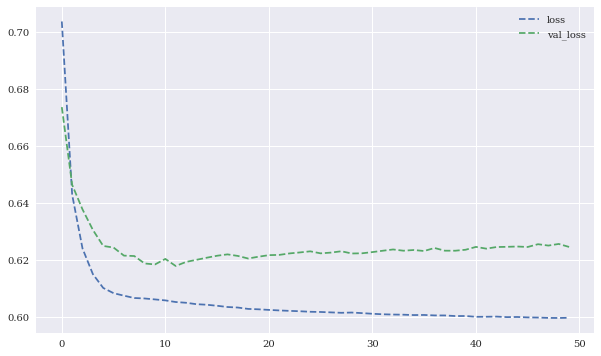

In [48]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

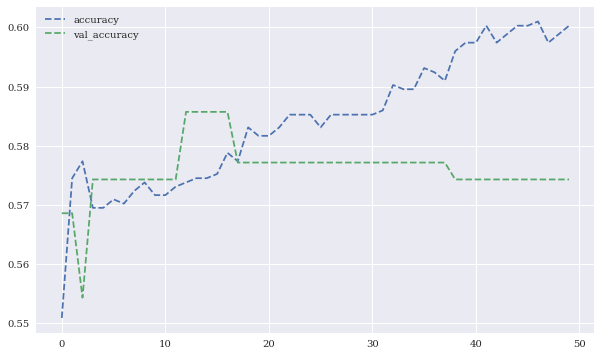

In [49]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Normalization

In [50]:
mu, std = train.mean(), train.std()

In [51]:
train_ = (train - mu) / std

In [52]:
#train_.std().round(3)

In [53]:
set_seeds()
model = create_model(hl=2, hu=128)

In [54]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 8.61 s, sys: 536 ms, total: 9.14 s
Wall time: 11.1 s


In [55]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.9198


[0.41909292340278625, 0.9198167324066162]

In [56]:
test_ = (test - mu) / std

In [57]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.4679 - accuracy: 0.6682


[1.467904806137085, 0.6681922078132629]

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               5248      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38,401
Trainable params: 38,401
Non-trainable params: 0
_________________________________________________________________


In [59]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [60]:
test['p'].value_counts()

0    285
1    152
Name: p, dtype: int64

In [61]:
res = pd.DataFrame(h.history)

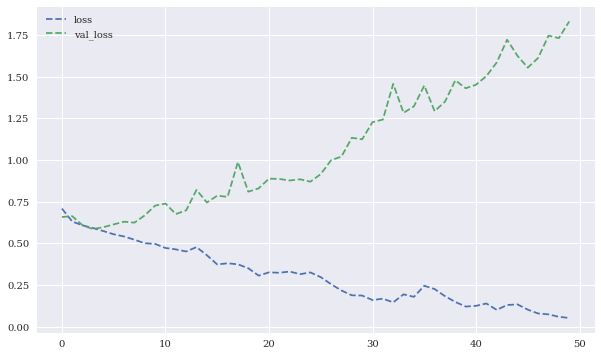

In [62]:
res[['loss','val_loss']].plot(figsize=(10,6),style='--');

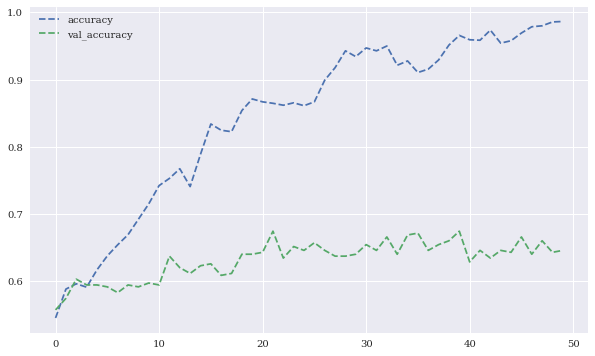

In [63]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Dropout 

In [64]:
from keras.layers import Dropout

In [65]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [66]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               5248      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 21,889
Trainable params: 21,889
Non-trainable params: 0
_________________________________________________________________


In [68]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

CPU times: user 8.19 s, sys: 526 ms, total: 8.71 s
Wall time: 10.9 s


In [69]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 1ms/step - loss: 0.4455 - accuracy: 0.7772


[0.44549334049224854, 0.7772050499916077]

In [70]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 3ms/step - loss: 0.5741 - accuracy: 0.6407


[0.5741218328475952, 0.6407322883605957]

In [71]:
res = pd.DataFrame(h.history)

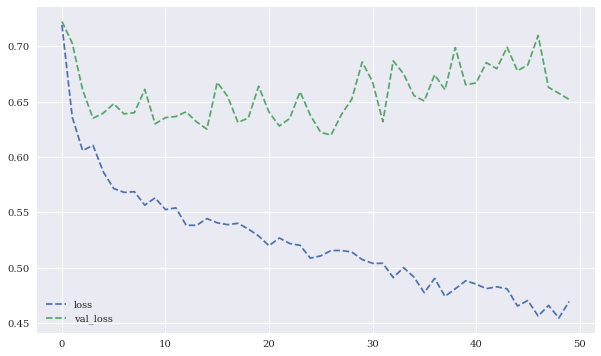

In [72]:
res[['loss','val_loss']].plot(figsize=(10,6),style='--');

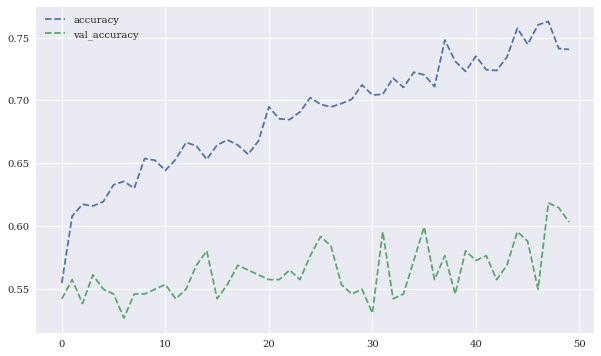

In [73]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Regularization 

In [74]:
from keras.regularizers import l1, l2

In [75]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [76]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [77]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 7.92 s, sys: 488 ms, total: 8.41 s
Wall time: 11 s


In [78]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.3610 - accuracy: 0.9026


[0.36104270815849304, 0.9026346206665039]

In [79]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.8612 - accuracy: 0.6636


[0.8611990809440613, 0.6636155843734741]

In [80]:
res = pd.DataFrame(h.history)

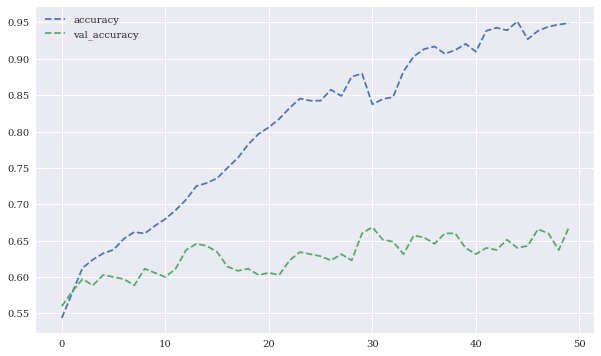

In [81]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [82]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.1791486680507659

## Bagging

In [83]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [84]:
len(cols)

40

In [85]:
max_features = 0.75

In [86]:
set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """


In [87]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [88]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 44.3 s, sys: 2.09 s, total: 46.4 s
Wall time: 48.6 s


BaggingClassifier(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f865b5e2d90>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [89]:
model_bag.score(train_[cols], train['d'])

0.7605956471935853

In [90]:
model_bag.score(test_[cols], test['d'])

0.665903890160183

In [91]:
test['p'] = model_bag.predict(test_[cols])

In [92]:
test['p'].value_counts()

0    380
1     57
Name: p, dtype: int64

## Optimizers

In [93]:
import time

In [94]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [95]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 8.0911 | in-sample=0.6077 | out-of-sample=0.6499
rmsprop    | time[s]: 11.3056 | in-sample=0.7176 | out-of-sample=0.6293
adagrad    | time[s]: 6.5107 | in-sample=0.5630 | out-of-sample=0.6293
adadelta   | time[s]: 10.8806 | in-sample=0.6438 | out-of-sample=0.6545
adam       | time[s]: 7.2118 | in-sample=0.7056 | out-of-sample=0.6522
adamax     | time[s]: 6.6877 | in-sample=0.6357 | out-of-sample=0.6613
nadam      | time[s]: 7.4873 | in-sample=0.7371 | out-of-sample=0.6499
CPU times: user 59.2 s, sys: 3.1 s, total: 1min 2s
Wall time: 1min


In [96]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [97]:
test['p'].value_counts()

0    247
1    190
Name: p, dtype: int64

In [98]:
accuracy_score(test['p'], test['d'])

0.6498855835240275

In [101]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0

    acc_tr = h.history['accuracy'][-1]
    acc_va = h.history['val_accuracy'][-1]

    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_va:.4f}'
    print(out)

sgd        | time[s]: 8.5313 | in-sample=0.6454 | out-of-sample=0.5829
rmsprop    | time[s]: 6.8924 | in-sample=0.7178 | out-of-sample=0.6143
adagrad    | time[s]: 6.4438 | in-sample=0.6196 | out-of-sample=0.5057
adadelta   | time[s]: 6.6232 | in-sample=0.6261 | out-of-sample=0.6114
adam       | time[s]: 10.8755 | in-sample=0.7393 | out-of-sample=0.6257
adamax     | time[s]: 10.8980 | in-sample=0.6848 | out-of-sample=0.6000
nadam      | time[s]: 8.0639 | in-sample=0.7328 | out-of-sample=0.6229
CPU times: user 57.8 s, sys: 2.79 s, total: 1min
Wall time: 58.7 s


In [109]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [110]:
%%time

optimizers = optimizers[4]
set_seeds()
model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )

t0 = time.time()

h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))

t1 = time.time()
t = t1 - t0

acc_te = h.history['val_accuracy'][-1]

out = f'{optimizer:10s} | time[s]: {t:.4f} | out-of-sample={acc_te:.4f}'

print(out)

nadam      | time[s]: 7.4790 | out-of-sample=0.6229
CPU times: user 9.23 s, sys: 390 ms, total: 9.62 s
Wall time: 7.53 s
